<a href="https://www.kaggle.com/code/parisrohan/featureengg-modelbuild-lr-dtr?scriptVersionId=101246655" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

plt.style.use("seaborn-whitegrid")
pd.pandas.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nyc-taxi-trip-duration/nyc_taxi_trip_duration.csv


In [2]:
#Read the dataset
df_data=pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/nyc_taxi_trip_duration.csv')
df_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [3]:
#shape of dataset
"The dataset has {} rows and {} columns".format(df_data.shape[0], df_data.shape[1])

'The dataset has 729322 rows and 11 columns'

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


## 1. Data preprocessing

### 1.1 Impute missing values

In [5]:
df_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Note:
* The dataset has no missing values -> So there is no need of imputation here

### 1.2. Create new features

Note:
* First, we will create a new feature named 'trip_distance' by calculating the distance between the pickup and dropoff coordinates.
* Next, we will create a new feature named 'avg_trip_speed' by considering 'trip_distance' and 'trip_duration'

In [6]:
df_data[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,729322.000000,729322.000000,729322.000000,729322.000000
mean,40.750919,-73.973513,40.751775,-73.973422
std,0.033594,0.069754,0.036037,0.069588
min,34.712234,-121.933342,32.181141,-121.933304
25%,40.737335,-73.991859,40.735931,-73.991318
50%,40.754070,-73.981758,40.754509,-73.979759
75%,40.768314,-73.967361,40.769741,-73.963036
max,51.881084,-65.897385,43.921028,-65.897385


Haversine formula to calculate the distance between two coordinates:-
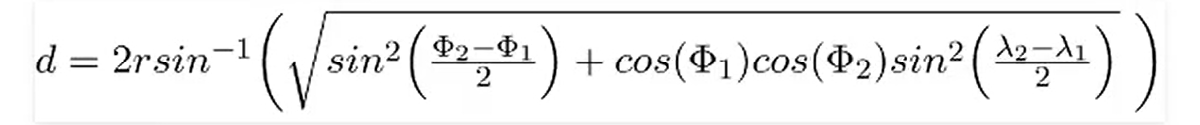

In [7]:
#Convert into radians
df_data['pickup_latitude']=np.radians(df_data['pickup_latitude'])
df_data['pickup_longitude']=np.radians(df_data['pickup_longitude'])
df_data['dropoff_latitude']=np.radians(df_data['dropoff_latitude'])
df_data['dropoff_longitude']=np.radians(df_data['dropoff_longitude'])

#Calculate the difference
df_data['latitude_diff']=df_data['dropoff_latitude']-df_data['pickup_latitude']
df_data['longitude_diff']=df_data['dropoff_longitude']-df_data['pickup_longitude']

#calculate the distance in meter
df_data['trip_distance']=1000 * 6371 * 2 * np.arcsin(
    np.sqrt(
        np.sin(df_data['latitude_diff']/2)**2
        + np.cos(df_data['pickup_latitude'])
        * np.cos(df_data['dropoff_latitude'])
        * np.sin(df_data['longitude_diff']/2)**2
    )
)

In [8]:
#Calculate speed in m/s
df_data['avg_trip_speed']=df_data['trip_distance']/df_data['trip_duration']

In [9]:
#Function to convert datetime features into datetime datatype and extract useful information
def convert_to_date_dtype(Dataframe,col):
    #function to convert the given feature into datetime
    Dataframe[col] = pd.to_datetime(Dataframe[col], format= '%Y-%m-%d %H:%M:%S')
    #extract required components from the datetime feature
    Dataframe[col+'_day'] = Dataframe[col].dt.dayofweek
    Dataframe[col+'_month'] = Dataframe[col].dt.month
    Dataframe[col+'_hour'] = Dataframe[col].dt.hour

In [10]:
#convert the features into datetime datatype
convert_to_date_dtype(df_data, 'pickup_datetime')
convert_to_date_dtype(df_data, 'dropoff_datetime')

df_data[['pickup_datetime', 'dropoff_datetime']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   pickup_datetime   729322 non-null  datetime64[ns]
 1   dropoff_datetime  729322 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 11.1 MB


### 1.3. Handle categorical values 

In [11]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      729322 non-null  object        
 1   vendor_id               729322 non-null  int64         
 2   pickup_datetime         729322 non-null  datetime64[ns]
 3   dropoff_datetime        729322 non-null  datetime64[ns]
 4   passenger_count         729322 non-null  int64         
 5   pickup_longitude        729322 non-null  float64       
 6   pickup_latitude         729322 non-null  float64       
 7   dropoff_longitude       729322 non-null  float64       
 8   dropoff_latitude        729322 non-null  float64       
 9   store_and_fwd_flag      729322 non-null  object        
 10  trip_duration           729322 non-null  int64         
 11  latitude_diff           729322 non-null  float64       
 12  longitude_diff          729322

In [12]:
#onehot encode and drop the first column
store_and_fwd_flag_onehot=pd.get_dummies(df_data['store_and_fwd_flag'],drop_first=True)

#concat the onehot encoded column to the main data frame
df_data=pd.concat([df_data,store_and_fwd_flag_onehot],axis=1)

In [13]:
df_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,latitude_diff,longitude_diff,trip_distance,avg_trip_speed,pickup_datetime_day,pickup_datetime_month,pickup_datetime_hour,dropoff_datetime_day,dropoff_datetime_month,dropoff_datetime_hour,Y
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-1.290739,0.711726,-1.290913,0.711591,N,400,-0.000135,-0.000174,1199.072614,2.997682,0,2,16,0,2,16,0
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-1.291340,0.710903,-1.291452,0.710261,N,1100,-0.000642,-0.000112,4129.110988,3.753737,4,3,23,4,3,23,0
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-1.291497,0.710724,-1.290637,0.711657,N,1635,0.000933,0.000860,7250.752890,4.434711,6,2,17,6,2,18,0
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-1.290875,0.711391,-1.290789,0.711756,N,1141,0.000365,0.000085,2361.097363,2.069323,1,1,9,1,1,10,0
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-1.291842,0.710497,-1.291337,0.711058,N,848,0.000561,0.000505,4328.533890,5.104403,2,2,6,2,2,6,0


### 1.4. Drop features that are not required

In [14]:
df_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'latitude_diff', 'longitude_diff', 'trip_distance',
       'avg_trip_speed', 'pickup_datetime_day', 'pickup_datetime_month',
       'pickup_datetime_hour', 'dropoff_datetime_day',
       'dropoff_datetime_month', 'dropoff_datetime_hour', 'Y'],
      dtype='object')

In [15]:
drop_cols=['id','pickup_datetime', 'dropoff_datetime','pickup_longitude', 'pickup_latitude',
          'dropoff_longitude', 'dropoff_latitude','store_and_fwd_flag','latitude_diff','longitude_diff']

df_data.drop(drop_cols,axis=1,inplace=True)

In [16]:
#make sure the columns have been dropped
df_data.columns

Index(['vendor_id', 'passenger_count', 'trip_duration', 'trip_distance',
       'avg_trip_speed', 'pickup_datetime_day', 'pickup_datetime_month',
       'pickup_datetime_hour', 'dropoff_datetime_day',
       'dropoff_datetime_month', 'dropoff_datetime_hour', 'Y'],
      dtype='object')

### 1.5. Treat 'vendor_id' as an object

In [17]:
df_data['vendor_id']=pd.get_dummies(df_data['vendor_id'],drop_first=True)

In [18]:
df_data.dtypes

vendor_id                   uint8
passenger_count             int64
trip_duration               int64
trip_distance             float64
avg_trip_speed            float64
pickup_datetime_day         int64
pickup_datetime_month       int64
pickup_datetime_hour        int64
dropoff_datetime_day        int64
dropoff_datetime_month      int64
dropoff_datetime_hour       int64
Y                           uint8
dtype: object

### 1.6. Transform target feature

count    7.293220e+05
mean     9.522291e+02
std      3.864626e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.630000e+02
75%      1.075000e+03
max      1.939736e+06
Name: trip_duration, dtype: float64

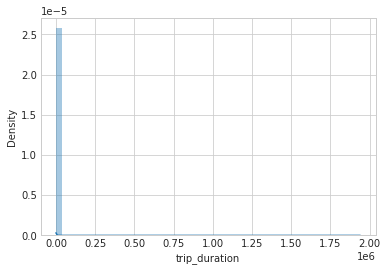

In [19]:
#Before transformation
sns.distplot(a=df_data['trip_duration'], bins=50)
df_data['trip_duration'].describe()

<AxesSubplot:xlabel='trip_duration', ylabel='Density'>

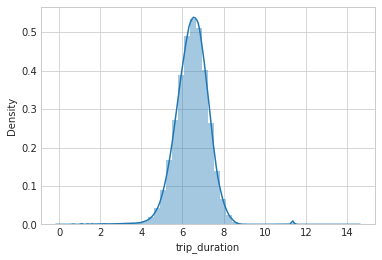

In [20]:
#After transformation
df_data['trip_duration']=np.log(df_data['trip_duration'])
sns.distplot(a=df_data['trip_duration'],bins=50)

## 2. Model Building

In [21]:
#seperate dependent and independent features
X=df_data.drop(['trip_duration'],axis=1)
y=df_data['trip_duration']

In [22]:
# Break off dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (510525, 11) (510525,)
Test (218797, 11) (218797,)


In [23]:
#Scale the data
ss=StandardScaler()

X_train_sc=ss.fit_transform(X_train)
X_test_sc=ss.transform(X_test)

### 2.1. Baseline model

In [24]:
#Baseline model using mean
baseline_pred=np.repeat(y_train.mean(),len(y_test))

print('MAE:', mean_absolute_error(y_test, baseline_pred))
print('MSE:', mean_squared_error(y_test, baseline_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, baseline_pred)))
print('R2', r2_score(y_test,baseline_pred))

MAE: 0.6079333062776178
MSE: 0.6446183209013729
RMSE: 0.8028812620190939
R2 -3.075551674758259e-05


### 2.2. Linear Regression Model

In [25]:
lr_model=LinearRegression()

lr_model.fit(X_train_sc,y_train)

LinearRegression()

In [26]:
pred=lr_model.predict(X_test_sc)

In [27]:
print('MAE:', mean_absolute_error(y_test, pred))
print('MSE:', mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
print('R2', r2_score(y_test,pred))

MAE: 0.37492412566037414
MSE: 0.30920350531655943
RMSE: 0.55606070290622
R2 0.5203161235042597


In [28]:
lr_model.coef_

array([ 9.26118781e-03,  5.92036669e-03,  6.99538786e-01, -4.37335719e-01,
       -2.48562886e-02, -1.14749181e+00,  6.20490040e-04,  1.58981277e-02,
        1.16738724e+00,  1.53462021e-02, -2.19606789e-03])

Text(0.5, 1.0, 'Linear Regression Coefficient plot')

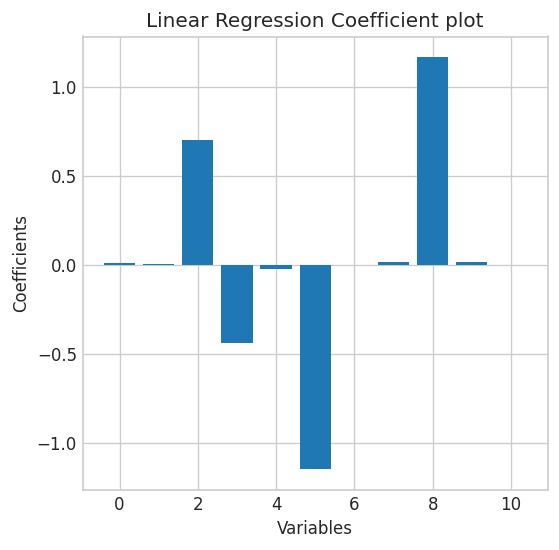

In [29]:
plt.figure(figsize=(5, 5), dpi=120, facecolor='w', edgecolor='b')
x = range(len(X_train.columns))
y = lr_model.coef_
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Linear Regression Coefficient plot')

### 2.3. Decision Tree Model

In [30]:
dtr_model=DecisionTreeRegressor(random_state=10)
dtr_model.fit(X_train_sc,y_train)

DecisionTreeRegressor(random_state=10)

In [31]:
pred=dtr_model.predict(X_test_sc)

In [32]:
print('MAE:', mean_absolute_error(y_test, pred))
print('MSE:', mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
print('R2', r2_score(y_test,pred))

MAE: 0.011576238565201253
MSE: 0.019888782901155207
RMSE: 0.1410275962397261
R2 0.9691454711322207
